In [1]:
# pieces of code taken from project qtplot
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import ndimage
plt.rcParams['figure.facecolor'] = 'white'

def create_kernel(x_dev, y_dev, cutoff, distr):
    distributions = {
        'gaussian': lambda r: np.exp(-(r**2) / 2.0),
        'exponential': lambda r: np.exp(-abs(r) * np.sqrt(2.0)),
        'lorentzian': lambda r: 1.0 / (r**2+1.0),
        'thermal': lambda r: np.exp(r) / (1 * (1+np.exp(r))**2)
    }
    func = distributions[distr]

    hx = int(np.floor((x_dev * cutoff) / 2.0))
    hy = int(np.floor((y_dev * cutoff) / 2.0))


    x = np.zeros(1) if x_dev==0 else np.linspace(-hx, hx, hx * 2 + 1) / x_dev
    y = np.zeros(1) if y_dev==0 else np.linspace(-hy, hy, hy * 2 + 1) / y_dev

    xv, yv = np.meshgrid(x, y)

    kernel = func(np.sqrt(xv**2+yv**2))
    kernel /= np.sum(kernel)

    return kernel

def yderiv(d):
    # https://en.wikipedia.org/wiki/Finite_difference_coefficient
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html
    y = d[1]
    z = d[2]
    dzdy0 = (z[1]-z[0])/(y[1]-y[0])
    dzdy1 = (z[-2]-z[-1])/(y[-2]-y[-1])
    z[1:-1] = (z[2:] - z[:-2])/(y[2:] - y[:-2])
    z[0] = dzdy0
    z[-1] = dzdy1

def lowpass(d, x_width=0.5, y_height=0.5, method='gaussian'):
    """Perform a low-pass filter."""
    z = d[2]
    kernel = create_kernel(x_width, y_height, 7, method)
    z[:] = ndimage.filters.convolve(z, kernel)

def scale(d,amp=[]):
    for i, ai in enumerate(amp):
        d[i] *= ai

def offset(d,off=[]):
    for i, oi in enumerate(off):
        d[i] += oi

def g_in_g2(d, rin):
    """z = z/(1-(z*Rin))/7.74809e-5. z: conductance in unit 'S', R in unit 'ohm' (SI units)"""
    G2 = 7.74809e-5#ohm^-1, 2e^2/h
    d[2] = d[2]/(1-(d[2]*rin))/G2

def readMTX(fPath):
    '''
    read 2D .mtx files, which have the form:
        Units, Dataset name, xname, xmin, xmax, yname, ymin, ymax, zname, zmin, zmax
        nx ny nz length
        [binary data....]
    '''
    with open(fPath, 'rb') as f:
        line1 = f.readline().decode().rstrip('\n\t\r')
        if line1.startswith('Units'):#MTX file
            _ = line1.split(',') 
            labels = [x.strip() for x in [_[2],_[5],_[8],_[1]]]
            line2 = f.readline().decode()
            shape = [int(x) for x in line2.split(' ')]
            x = np.linspace(float(_[3]),float(_[4]),shape[0])
            y = np.linspace(float(_[6]),float(_[7]),shape[1])
            z = np.linspace(float(_[9]),float(_[10]),shape[2])
            z,y,x = np.meshgrid(z,y,x,indexing='ij')
            dtp = np.float64 if shape[3] == 8 else np.float32#data type
            shape = shape[0:3]
            w = np.fromfile(f,dtype=dtp).reshape(shape).T
            if shape[2] == 1:# only care about .mtx files with 2D data
                return x[0],y[0],w[0],[labels[0],labels[1],labels[3]]

def readDat(fPath,cols=[0,1,3],cook=None,a3=2,a3index=0):
    '''
    read .dat files
    '''
    sizes = []# nx,ny,nz for each dimension of scan. Assume a 3D scan (1D and 2D are also kinds of 3D).
    labels = []# labels for each column
    # read comments
    with open(fPath, 'r') as f:
        for line in f:
            line = line.rstrip('\n\t\r')
            if line.startswith('#\tname'):
                labels.append(line.split(': ', 1)[1])
            elif line.startswith('#\tsize'):
                sizes.append(int(line.split(': ', 1)[1]))
            if len(line) > 0 and line[0] != '#':# where comments end
                break
    # load data
    print('File: %s, cols: %s'%(os.path.split(fPath)[1],[labels[i] for i in cols]))
    d = np.loadtxt(fPath,usecols=cols)
    
    #assume this is data from a 3D scan, we call the element of D1/D2/D3 the point/line/page
    n_per_line = sizes[0]
    n_per_page = sizes[0]*sizes[1]
    n_dp = d.shape[0]# Real number of datapoints
    n_pg = int(np.ceil(float(n_dp)/n_per_page))# number of pages, it may be smaller than sizes[2] because sometimes the scan is interrupted by a user
    
    pivot = np.full((len(cols),n_per_page*n_pg), np.nan)# initialize with na.nan
    pivot[:,:n_dp] = d.T
    pivot = pivot.reshape([len(cols),n_pg,sizes[1],sizes[0]])

    # You have a 3D scan, you want to extract a 2D slice. a3 and a3index are the parameters for slicing
    if a3 == 0:#slice with x_index=const
        pivot = pivot[:,:,:,a3index]
    elif a3 == 1:#y_ind=const
        pivot = pivot[:,:,a3index,:]
    elif a3 == 2:#z_ind=const
        pivot = pivot[:,a3index,:,:]
    
    # remove nan lines in x,y,w...
    nans = np.isnan(pivot[0,:,0])
    pivot = pivot[:,~nans,:]
    
    # Some values in the last line of x and y may be nan. Recalculate these values. Keep w untouched.
    nans = np.isnan(pivot[0,-1,:])
    pivot[:2,-1,nans] = pivot[:2,-2,nans]*2.-pivot[:2,-3,nans]
    
    # autoflip for filters and imshow()
    pivot = autoflip(pivot)
    
    if cook:
        cook(pivot)

    x,y,w = pivot[:3]
    return x,y,w,[labels[cols[i]] for i in range(3)]

def autoflip(d):
    # Make the order of elements in x and y good for imshow() and filters
    x = d[0]
    y = d[1]
    xa = abs(x[0,0]-x[0,-1])
    xb = abs(x[0,0]-x[-1,0])
    ya = abs(y[0,0]-y[0,-1])
    yb = abs(y[0,0]-y[-1,0])
    if (xa<xb and yb<ya) or (xa>xb and yb<ya and yb/ya<xb/xa) or (xa<xb and yb>ya and ya/yb>xa/xb):
        d = np.transpose(d, (0, 2, 1))# swap axis 1 and 2
    x = d[0]#note: x y won't unpdate after d changes. There maybe nan in last lines of x and y.
    y = d[1]
    if x[0,0]>x[0,-1]:
        d = d[:,:,::-1]
    if y[0,0]>y[-1,0]:
        d = d[:,::-1,:]
    return d
        
def get_quad(x):
    '''
    Calculate the patch corners for pcolormesh
    More discussion can be found here: https://cover-me.github.io/2019/02/17/Save-2d-data-as-a-figure.html, https://cover-me.github.io/2019/04/04/Save-2d-data-as-a-figure-II.html
    '''
    l0, l1 = x[:,[0]], x[:,[1]]
    r1, r0 = x[:,[-2]], x[:,[-1]]
    x = np.hstack((2*l0 - l1, x, 2*r0 - r1))
    t0, t1 = x[0], x[1]
    b1, b0 = x[-2], x[-1]
    x = np.vstack([2*t0 - t1, x, 2*b0 - b1])
    x = (x[:-1,:-1]+x[:-1,1:]+x[1:,:-1]+x[1:,1:])/4.  
    return x

def plotMTX(fPath,**kw):
    x,y,w,labels = readMTX(fPath)
    if 'labels' not in kw:
        kw['labels'] = labels
    return plot2d(x,y,w,**kw)
    
def plotDat(fPath,cols=[0,1,3],cook=None,**kw):
    x,y,w,labels = readDat(fPath,cols,cook)
    if 'labels' not in kw:
        kw['labels'] = labels
    return plot2d(x,y,w,**kw)
    
def plot2d(x,y,w,**kw):
    '''Plot 2D figure'''
    #plot settings
    ps = {'labels':['','',''],'useImshow':True,'gamma':0,'gmode':'moveColor',
          'cmap':'seismic','vmin':None, 'vmax':None,'plotCbar':True}
    for i in ps:
        if i in kw:
            ps[i] = kw[i]
    if 'ax' in kw and 'fig' in kw:
        # sometimes you want to use customized axes
        fig = kw['fig']
        ax = kw['ax']
    else:
        fig, ax = plt.subplots(figsize=(3.375,2),dpi=120)

    x1 = get_quad(x)
    y1 = get_quad(y)    
    imkw = {'cmap':ps['cmap'],'vmin':ps['vmin'],'vmax':ps['vmax']}
    gamma_real = 10.0**(ps['gamma'] / 100.0)#to be consistent with qtplot
    if gamma_real != 1:
        if ps['gmode']=='moveColor':
            _ = 1024# default: 256
            cmap = mpl.cm.get_cmap(imkw['cmap'], _)
            cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, _)**gamma_real))
            imkw['cmap'] = cmap
        else:
            imkw['norm'] = mpl.colors.PowerNorm(gamma=gamma_real)
    
    if ps['useImshow']:#slightly different from pcolormesh, especially if saved as vector formats. Imshow is better if it works. See the links in get_quad().
        xy_range = (x1[0,0],x1[0,-1],y1[0,0],y1[-1,0])
        im = ax.imshow(w,aspect='auto',interpolation='none',origin='lower',extent=xy_range,**imkw)
    else:
        im = ax.pcolormesh(x1,y1,w,**imkw)

    if ps['plotCbar']:
        cbar = fig.colorbar(im,ax=ax)
        cbar.ax.set_ylabel(ps['labels'][2])
    else:
        cbar = None
    ax.set_xlabel(ps['labels'][0])
    ax.set_ylabel(ps['labels'][1])
    
    return fig,ax,cbar,im


# Plot .dat data
Parameters for loading data:
```
cols: index numbers of columns for x, y, w and more (if you need to process data with more columns)
cook: a function to cook the data
```
Parameters for plotting
```
{'labels':['','',''],'useImshow':True,'gamma':0,'gmode':'moveColor',
          'cmap':'seismic','vmin':None, 'vmax':None,'plotCbar':True}
```

File: datS2002_283.dat, cols: ['dac11_(G1+G3(5mV))', 'dac1_(Vbias(0.01mV))', 'keithley1 (e-6A)']


(<Figure size 405x240 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x50b3a88>)

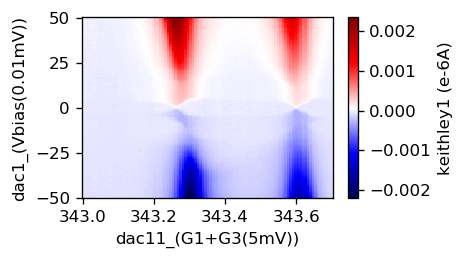

In [2]:
kw = {'cols':[1,0,3]}
plotDat(r'datS2002_283.dat',**kw)

# Apply filters and customize the figure

File: datS2002_283.dat, cols: ['dac11_(G1+G3(5mV))', 'dac1_(Vbias(0.01mV))', 'keithley1 (e-6A)']


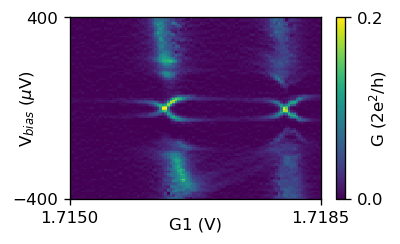

In [3]:
#The function that cooks the data
def foo(d):
    scale(d,[5e-3,0.01e-3,1e-6])#scale everything to SI units, scale(d,[sx,sy,sz,...])
    lowpass(d,0.5,0.5)
    yderiv(d)
    g_in_g2(d,4440)
    scale(d,[1,1e6,1])#scale again to desired units
    #offset(d,[0,0])#offset(d,[offx,offy,offz,...])
    
# load and plot
kw = {'cols':[1,0,3],'cook':foo,
      'labels':['G1 (V)','V$_{bias}$ ($\mu$V)','G (2e$^2$/h)'],
      'cmap':'viridis'}
fig,ax,cbar,im = plotDat(r'datS2002_283.dat',**kw)

# customize the figure
xlim = [1.715,1.7185]
ax.set_xlim(*xlim)
ax.set_xticks(xlim)
ax.xaxis.labelpad = -5

ylim = [-400,400]
ax.set_ylim(*ylim)
ax.set_yticks(ylim)
ax.yaxis.labelpad = -15

clim = [0,0.2]
im.set_clim(*clim)
cbar.set_ticks(clim)
cbar.set_label(kw['labels'][2],labelpad=-10)#somehow the label is missing after set_clim

# Subtract V$_{Rin}$ from V$_{bias}$

Set 'useImshow':False so pcolormesh() is used instead of imshow(). 

File: data_147.dat, cols: ['dac2_(Bg(*5 mV))', 'dac1_(Vbias(0.01mV))', '2e2/h', 'keithley1 (*1e-6A)']


(<Figure size 405x240 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x87f5d48>)

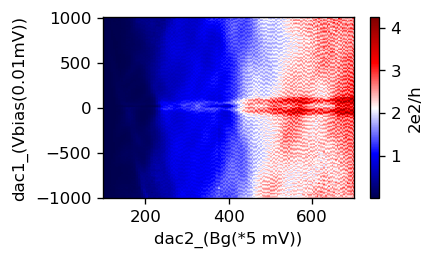

In [4]:
kw = {'cols':[1,0,7,3]}#import 4 columns instead of 3
plotDat(r'data_147.dat',**kw)

File: data_147.dat, cols: ['dac2_(Bg(*5 mV))', 'dac1_(Vbias(0.01mV))', '2e2/h', 'keithley1 (*1e-6A)']


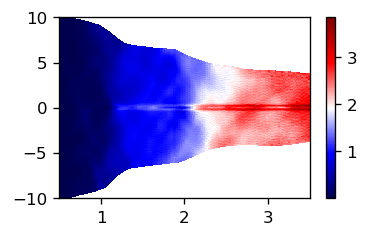

In [5]:
def foo(d):
    scale(d,[5e-3,0.01e-3,1,1e-6])#also scale d[3]
    lowpass(d,0.5,1)
    d[1] -= 7100*d[3]
    scale(d,[1,1000])
kw = {'cols':[1,0,7,3],'cook':foo,'useImshow':False,'labels':['','','']}
fig,ax,cbar,im = plotDat(r'data_147.dat',**kw)

# plot .mtx
Also shows two styles of colorbar with non-zero gammas

(<Figure size 405x240 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x8ab5f08>)

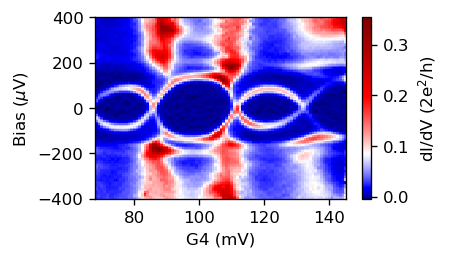

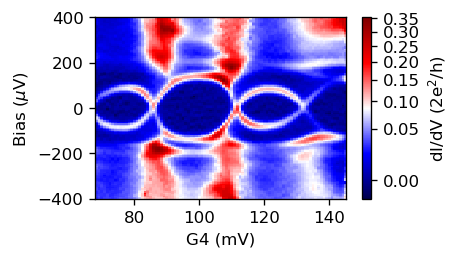

In [6]:
plotMTX('datS1910_212.mtx',gamma=-30)
plotMTX('datS1910_212.mtx',gamma=-30,gmode='')

# Multiple panels

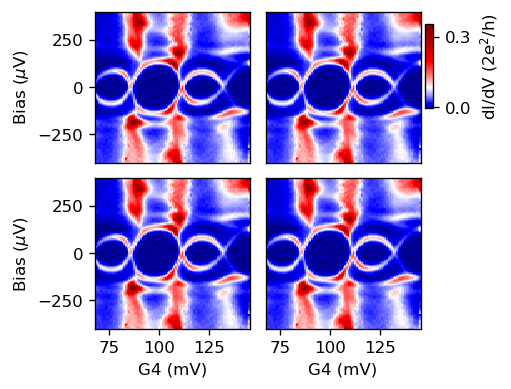

In [7]:
fig, axs = plt.subplots(2,2,dpi=120,figsize=(3.5,3.5))
plt.subplots_adjust(hspace=0.1,wspace=0.1)
for i,axi in zip([212,212,212,212],axs.ravel()):
    plotMTX('datS1910_%d.mtx'%i,ax=axi,fig=fig,plotCbar=False,gamma=-30)

axs[0,0].set_xticks([])
axs[0,1].set_xticks([])

axs[0,1].set_yticks([])
axs[1,1].set_yticks([])

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')

axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')

cax = fig.add_axes([0.91,0.65,0.02,0.2])
im = [obj for obj in axs[0,0].get_children() if isinstance(obj, mpl.image.AxesImage) or isinstance(obj,mpl.collections.QuadMesh)][0]
# make sure all panels have the same colorscale as you only plot one colorbar!
fig.colorbar(im,cax=cax,ticks=[0,0.3],label='dI/dV (2e$^2$/h)')